In [ ]:
"""
analysis.ipynb

Notebook to perform ROC plotting, AUC calculation, and t-SNE visualization
on original vs. encoded embeddings for both label 1 and label 2.
Saves the figures to the config directory.

Dependencies:
    - numpy
    - matplotlib
    - seaborn
    - scikit-learn
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.manifold import TSNE
from torch import nn
import torch

# Seaborn style
sns.set(style="whitegrid")

class MLP(nn.Module):
    
        def __init__(self, input_size=512, hidden_size=256, output_size=1):
            super(MLP, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(input_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, output_size),
                nn.Sigmoid(),
            )

        def forward(self, x):
            """
            Forward pass of the MLP.

            Args:
                x (torch.Tensor): Input tensor.

            Returns:
                torch.Tensor: Output logits in [0,1] range for binary classification.
            """
            return self.model(x)

def plot_roc_curve(preds, labels, title="ROC Curve", save_path=None):
    """
    Plot the ROC curve and compute the AUC.

    This function plots the ROC curve given predictions and labels,
    prints the AUC, and optionally saves the figure.

    Args:
        preds: Model predictions (floats in [0,1]).
        labels: Ground truth labels (0 or 1).
        title: Title for the plot.
        save_path: File path to save the figure (if not None).

    Returns:
        float: The computed AUC value.
    """
    fpr, tpr, _ = roc_curve(labels, preds)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")

    # Save figure if a path is provided
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Figure saved to: {save_path}")

    plt.show()
    return roc_auc


def visualize_tsne(embeddings, labels, title="t-SNE Visualization", save_path=None):
    """
    Create a 2D t-SNE projection of high-dimensional embeddings and color by label.

    This function reduces the dimensionality of embeddings to 2D via t-SNE
    and plots them, optionally saving the figure.

    Args:
        embeddings: N x D array of embeddings.
        labels: Binary labels (0 or 1) to color the embeddings.
        title: Title for the plot.
        save_path: File path to save the figure (if not None).

    Returns:
        None
    """
    
    model1 = MLP(
        input_size=512, hidden_size=512 // 2, output_size=1
    )

    model2 = MLP(
        input_size=512, hidden_size=512 // 2, output_size=1
    )

    model1_enc = MLP(
        input_size=512, hidden_size=512 // 2, output_size=1
    )

    model2_enc = MLP(
        input_size=512, hidden_size=512 // 2, output_size=1
    )

    torch.save(model1.state_dict(), 'vctk_model1_state.pth')
    torch.save(model2.state_dict(), 'vctk_model2_state.pth')
    torch.save(model1_enc.state_dict(), 'vctk_model1_enc_state.pth')
    torch.save(model2_enc.state_dict(), 'vctk_model2_enc_state.pth')

    checkpoint_path = "vctk_model1_state.pth"
    state_dict = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model1.load_state_dict(state_dict)
    model1.eval()

    checkpoint_path = "vctk_model2_state.pth"
    state_dict = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model2.load_state_dict(state_dict)
    model2.eval()

    checkpoint_path = "vctk_model1_enc_state.pth"
    state_dict = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model1_enc.load_state_dict(state_dict)
    model1_enc.eval()

    checkpoint_path = "vctk_model2_enc_state.pth"
    state_dict = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model2_enc.load_state_dict(state_dict)
    model2_enc.eval()

    feature_extractor1 = nn.Sequential(*list(model1.children())[:-1])
    feature_extractor1.eval()

    feature_extractor2 = nn.Sequential(*list(model2.children())[:-1])
    feature_extractor2.eval()

    feature_extractor1_enc = nn.Sequential(*list(model1_enc.children())[:-1])
    feature_extractor1_enc.eval()

    feature_extractor2_enc = nn.Sequential(*list(model2_enc.children())[:-1])
    feature_extractor2_enc.eval()

    features1 = []
    features2 = []
    features1_enc = []
    features2_enc = []

    with torch.no_grad():
        for emb in embeddings:
            print("A")
            print(embeddings.shape)
            print(emb.shape)
            embedding1 = feature_extractor1(emb)  # Extract features
            embedding2 = feature_extractor2(emb)
            embedding1_enc = feature_extractor1_enc(emb)
            embedding2_enc = feature_extractor2_enc(emb)

        
            features1.append(embedding1)
            features2.append(embedding2)
            features1_enc.append(embedding1_enc)
            features2_enc.append(embedding2_enc)


    features1 = np.vstack(features1)
    features2 = np.vstack(features2)
    features1_enc = np.vstack(features1_enc)
    features2_enc = np.vstack(features2_enc)

    tsne1 = TSNE(n_components=10, random_state=42, perplexity=30)
    reduced1 = tsne1.fit_transform(features1)

    tsne2 = TSNE(n_components=10, random_state=42, perplexity=30)
    reduced2 = tsne2.fit_transform(features2)

    tsne1_enc = TSNE(n_components=10, random_state=42, perplexity=30)
    reduced1_enc = tsne1_enc.fit_transform(features1_enc)

    tsne2_enc = TSNE(n_components=10, random_state=42, perplexity=30)
    reduced2_enc = tsne2_enc.fit_transform(features2_enc)

    plt.figure(figsize=(7, 7))
    scatter = plt.scatter(
        reduced1[:, 0],
        reduced1[:, 1],
        c=labels,
        cmap="coolwarm",
        alpha=0.7
    )
    cbar = plt.colorbar(scatter)
    cbar.set_label("Label")
    plt.title(title)
    plt.xlabel("t-SNE dimension 1")
    plt.ylabel("t-SNE dimension 2")

    # Save figure if a path is provided
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"t-SNE figure saved to: {save_path}")

    plt.show()

    plt.figure(figsize=(7, 7))
    scatter = plt.scatter(
        reduced2[:, 0],
        reduced2[:, 1],
        c=labels,
        cmap="coolwarm",
        alpha=0.7
    )
    cbar = plt.colorbar(scatter)
    cbar.set_label("Label")
    plt.title(title)
    plt.xlabel("t-SNE dimension 1")
    plt.ylabel("t-SNE dimension 2")

    # Save figure if a path is provided
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"t-SNE figure saved to: {save_path}")

    plt.show()

    plt.figure(figsize=(7, 7))
    scatter = plt.scatter(
        reduced1_enc[:, 0],
        reduced1_enc[:, 1],
        c=labels,
        cmap="coolwarm",
        alpha=0.7
    )
    cbar = plt.colorbar(scatter)
    cbar.set_label("Label")
    plt.title(title)
    plt.xlabel("t-SNE dimension 1")
    plt.ylabel("t-SNE dimension 2")

    # Save figure if a path is provided
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"t-SNE figure saved to: {save_path}")

    plt.show()

    plt.figure(figsize=(7, 7))
    scatter = plt.scatter(
        reduced2_enc[:, 0],
        reduced2_enc[:, 1],
        c=labels,
        cmap="coolwarm",
        alpha=0.7
    )
    cbar = plt.colorbar(scatter)
    cbar.set_label("Label")
    plt.title(title)
    plt.xlabel("t-SNE dimension 1")
    plt.ylabel("t-SNE dimension 2")

    # Save figure if a path is provided
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"t-SNE figure saved to: {save_path}")

    plt.show()


In [ ]:
"""
analysis.ipynb

Notebook to perform ROC plotting, AUC calculation, and t-SNE visualization
on original vs. encoded embeddings for both label 1 and label 2.
Saves the figures to the config directory.

Dependencies:
    - numpy
    - matplotlib
    - seaborn
    - scikit-learn
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.manifold import TSNE
from torch import nn
import torch

# Seaborn style
sns.set(style="whitegrid")

class MLP(nn.Module):
    
        def __init__(self, input_size=512, hidden_size=256, output_size=1):
            super(MLP, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(input_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, output_size),
                nn.Sigmoid(),
            )

        def forward(self, x):
            """
            Forward pass of the MLP.

            Args:
                x (torch.Tensor): Input tensor.

            Returns:
                torch.Tensor: Output logits in [0,1] range for binary classification.
            """
            return self.model(x)

def plot_roc_curve(preds, labels, title="ROC Curve", save_path=None):
    """
    Plot the ROC curve and compute the AUC.

    This function plots the ROC curve given predictions and labels,
    prints the AUC, and optionally saves the figure.

    Args:
        preds: Model predictions (floats in [0,1]).
        labels: Ground truth labels (0 or 1).
        title: Title for the plot.
        save_path: File path to save the figure (if not None).

    Returns:
        float: The computed AUC value.
    """
    fpr, tpr, _ = roc_curve(labels, preds)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")

    # Save figure if a path is provided
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Figure saved to: {save_path}")

    plt.show()
    return roc_auc


def visualize_tsne(orig_embeddings, encoded_embeddings, labels1, labels2, config_path: str, title="t-SNE Visualization", save_path=None):
    """
    Create a 2D t-SNE projection of high-dimensional embeddings and color by label.

    This function reduces the dimensionality of embeddings to 2D via t-SNE
    and plots them, optionally saving the figure.

    Args:
        embeddings: N x D array of embeddings.
        labels: Binary labels (0 or 1) to color the embeddings.
        title: Title for the plot.
        save_path: File path to save the figure (if not None).

    Returns:
        None
    """
    
    model1 = MLP(
        input_size=512, hidden_size=512 // 2, output_size=1
    )

    model2 = MLP(
        input_size=512, hidden_size=512 // 2, output_size=1
    )

    model1_enc = MLP(
        input_size=64, hidden_size=64 // 2 * 4, output_size=1
    )

    model2_enc = MLP(
        input_size=64, hidden_size=64 // 2 * 4, output_size=1
    )

    checkpoint_path = f"{config_path}/model1_state.pth"
    state_dict = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model1.load_state_dict(state_dict)
    model1.eval()

    checkpoint_path =f"{config_path}/model2_state.pth"
    state_dict = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model2.load_state_dict(state_dict)
    model2.eval()

    checkpoint_path = f"{config_path}/model1_enc_state.pth"
    state_dict = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model1_enc.load_state_dict(state_dict)
    model1_enc.eval()

    checkpoint_path = f"{config_path}/model2_enc_state.pth"
    state_dict = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model2_enc.load_state_dict(state_dict)
    model2_enc.eval()

    feature_extractor1 = nn.Sequential(*list(model1.children())[:-1])
    feature_extractor1.eval()

    feature_extractor2 = nn.Sequential(*list(model2.children())[:-1])
    feature_extractor2.eval()

    feature_extractor1_enc = nn.Sequential(*list(model1_enc.children())[:-1])
    feature_extractor1_enc.eval()

    feature_extractor2_enc = nn.Sequential(*list(model2_enc.children())[:-1])
    feature_extractor2_enc.eval()

    features1 = []
    features2 = []
    features1_enc = []
    features2_enc = []

    with torch.no_grad():
        for orig_embedding, encoded_embedding in zip(orig_embeddings, encoded_embeddings):
            print("A")
            print(orig_embedding.shape)
            print(encoded_embedding.shape)
            embedding1 = feature_extractor1(orig_embedding)  # Extract features
            embedding2 = feature_extractor2(orig_embedding)
            embedding1_enc = feature_extractor1_enc(encoded_embedding)
            embedding2_enc = feature_extractor2_enc(encoded_embedding)

        
            features1.append(embedding1)
            features2.append(embedding2)
            features1_enc.append(embedding1_enc)
            features2_enc.append(embedding2_enc)


    features1 = np.vstack(features1)
    features2 = np.vstack(features2)
    features1_enc = np.vstack(features1_enc)
    features2_enc = np.vstack(features2_enc)

    tsne1 = TSNE(n_components=2, random_state=42, perplexity=30)
    reduced1 = tsne1.fit_transform(features1)

    tsne2 = TSNE(n_components=2, random_state=42, perplexity=30)
    reduced2 = tsne2.fit_transform(features2)

    tsne1_enc = TSNE(n_components=2, random_state=42, perplexity=30)
    reduced1_enc = tsne1_enc.fit_transform(features1_enc)

    tsne2_enc = TSNE(n_components=2, random_state=42, perplexity=30)
    reduced2_enc = tsne2_enc.fit_transform(features2_enc)

    plt.figure(figsize=(7, 7))
    scatter = plt.scatter(
        reduced1[:, 0],
        reduced1[:, 1],
        c=labels1,
        cmap="coolwarm",
        alpha=0.7
    )
    cbar = plt.colorbar(scatter)
    cbar.set_label("Label")
    plt.title(title)
    plt.xlabel("t-SNE dimension 1")
    plt.ylabel("t-SNE dimension 2")

    # Save figure if a path is provided
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"t-SNE figure saved to: {save_path}")

    plt.show()

    plt.figure(figsize=(7, 7))
    scatter = plt.scatter(
        reduced2[:, 0],
        reduced2[:, 1],
        c=labels2,
        cmap="coolwarm",
        alpha=0.7
    )
    cbar = plt.colorbar(scatter)
    cbar.set_label("Label")
    plt.title(title)
    plt.xlabel("t-SNE dimension 1")
    plt.ylabel("t-SNE dimension 2")

    # Save figure if a path is provided
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"t-SNE figure saved to: {save_path}")

    plt.show()

    plt.figure(figsize=(7, 7))
    scatter = plt.scatter(
        reduced1_enc[:, 0],
        reduced1_enc[:, 1],
        c=labels1,
        cmap="coolwarm",
        alpha=0.7
    )
    cbar = plt.colorbar(scatter)
    cbar.set_label("Label")
    plt.title(title)
    plt.xlabel("t-SNE dimension 1")
    plt.ylabel("t-SNE dimension 2")

    # Save figure if a path is provided
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"t-SNE figure saved to: {save_path}")

    plt.show()

    plt.figure(figsize=(7, 7))
    scatter = plt.scatter(
        reduced2_enc[:, 0],
        reduced2_enc[:, 1],
        c=labels2,
        cmap="coolwarm",
        alpha=0.7
    )
    cbar = plt.colorbar(scatter)
    cbar.set_label("Label")
    plt.title(title)
    plt.xlabel("t-SNE dimension 1")
    plt.ylabel("t-SNE dimension 2")

    # Save figure if a path is provided
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"t-SNE figure saved to: {save_path}")

    plt.show()

In [ ]:
"""
analysis.ipynb

Notebook to perform ROC plotting, AUC calculation, and t-SNE visualization
on original vs. encoded embeddings for both label 1 and label 2.
Saves the figures to the config directory.

Dependencies:
    - numpy
    - matplotlib
    - seaborn
    - scikit-learn
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.manifold import TSNE

# Seaborn style
sns.set(style="whitegrid")


def plot_roc_curve(preds, labels, title="ROC Curve", save_path=None):
    """
    Plot the ROC curve and compute the AUC.

    This function plots the ROC curve given predictions and labels,
    prints the AUC, and optionally saves the figure.

    Args:
        preds: Model predictions (floats in [0,1]).
        labels: Ground truth labels (0 or 1).
        title: Title for the plot.
        save_path: File path to save the figure (if not None).

    Returns:
        float: The computed AUC value.
    """
    fpr, tpr, _ = roc_curve(labels, preds)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")

    # Save figure if a path is provided
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Figure saved to: {save_path}")

    plt.show()
    return roc_auc

"""
def visualize_tsne(embeddings, labels, title="t-SNE Visualization", save_path=None):
    tsne = TSNE(n_components=2, random_state=42)
    reduced = tsne.fit_transform(embeddings)

    plt.figure(figsize=(7, 7))
    scatter = plt.scatter(
        reduced[:, 0],
        reduced[:, 1],
        c=labels,
        cmap="coolwarm",
        alpha=0.7
    )
    cbar = plt.colorbar(scatter)
    cbar.set_label("Label")
    plt.title(title)
    plt.xlabel("t-SNE dimension 1")
    plt.ylabel("t-SNE dimension 2")

    # Save figure if a path is provided
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"t-SNE figure saved to: {save_path}")

    plt.show()
"""

In [ ]:
# ============================
# Adjust these paths as needed
# ============================
config_path = "exps/training/2025-02-19_22-37-33"  # same as used in your training script

# Load predictions and labels
pred1_orig = np.load(f"{config_path}/pred1_orig.npy")
labels1_orig = np.load(f"{config_path}/labels1_orig.npy")
pred2_orig = np.load(f"{config_path}/pred2_orig.npy")
labels2_orig = np.load(f"{config_path}/labels2_orig.npy")

pred1_enc = np.load(f"{config_path}/pred1_enc.npy")
labels1_enc = np.load(f"{config_path}/labels1_enc.npy")
pred2_enc = np.load(f"{config_path}/pred2_enc.npy")
labels2_enc = np.load(f"{config_path}/labels2_enc.npy")

# Load embeddings for t-SNE
train_embeddings_original = np.load(f"{config_path}/train_embeddings_original.npy")
test_embeddings_original = np.load(f"{config_path}/test_embeddings_original.npy")
train_embeddings_encoded = np.load(f"{config_path}/train_embeddings_encoded.npy")
test_embeddings_encoded = np.load(f"{config_path}/test_embeddings_encoded.npy")

# =====================
# ROC & AUC for Label 1
# =====================
auc_label1_orig = plot_roc_curve(
    preds=pred1_orig,
    labels=labels1_orig,
    title="ROC - Label1 (Original)",
    save_path=f"{config_path}/ROC_label1_original.png"
)
auc_label1_enc = plot_roc_curve(
    preds=pred1_enc,
    labels=labels1_enc,
    title="ROC - Label1 (Encoded)",
    save_path=f"{config_path}/ROC_label1_encoded.png"
)
print(f"AUC for Label1 (Original): {auc_label1_orig:.4f}")
print(f"AUC for Label1 (Encoded): {auc_label1_enc:.4f}")

# =====================
# ROC & AUC for Label 2
# =====================
auc_label2_orig = plot_roc_curve(
    preds=pred2_orig,
    labels=labels2_orig,
    title="ROC - Label2 (Original)",
    save_path=f"{config_path}/ROC_label2_original.png"
)
auc_label2_enc = plot_roc_curve(
    preds=pred2_enc,
    labels=labels2_enc,
    title="ROC - Label2 (Encoded)",
    save_path=f"{config_path}/ROC_label2_encoded.png"
)
print(f"AUC for Label2 (Original): {auc_label2_orig:.4f}")
print(f"AUC for Label2 (Encoded): {auc_label2_enc:.4f}")

# ======================================
# t-SNE: Original vs Encoded Embeddings
# ======================================
# Here, we show examples using the test set, but you can also do it for the train set.
# We assume label1 and label2 come from different .npy label files,
# so you might want to combine them or pick one set.

# For demonstration, let's use "labels1_orig" for the test set coloring.
print("\nPerforming t-SNE on Original Test Embeddings (Label1 as color) ...")
visualize_tsne(
    orig_embeddings=test_embeddings_original,
    encoded_embeddings=test_embeddings_encoded,
    labels1=labels1_orig,
    labels2=labels2_orig,
    config_path=config_path,
    title="t-SNE (Original Test Embeddings, Label1)",
    save_path=f"{config_path}/TSNE_original_label1.png"
)


print("All ROC figures and t-SNE plots have been saved to:", config_path)


Combined ROC figure saved to: exps/training/2025-02-20_07-03-41/ROC_label1_all.png


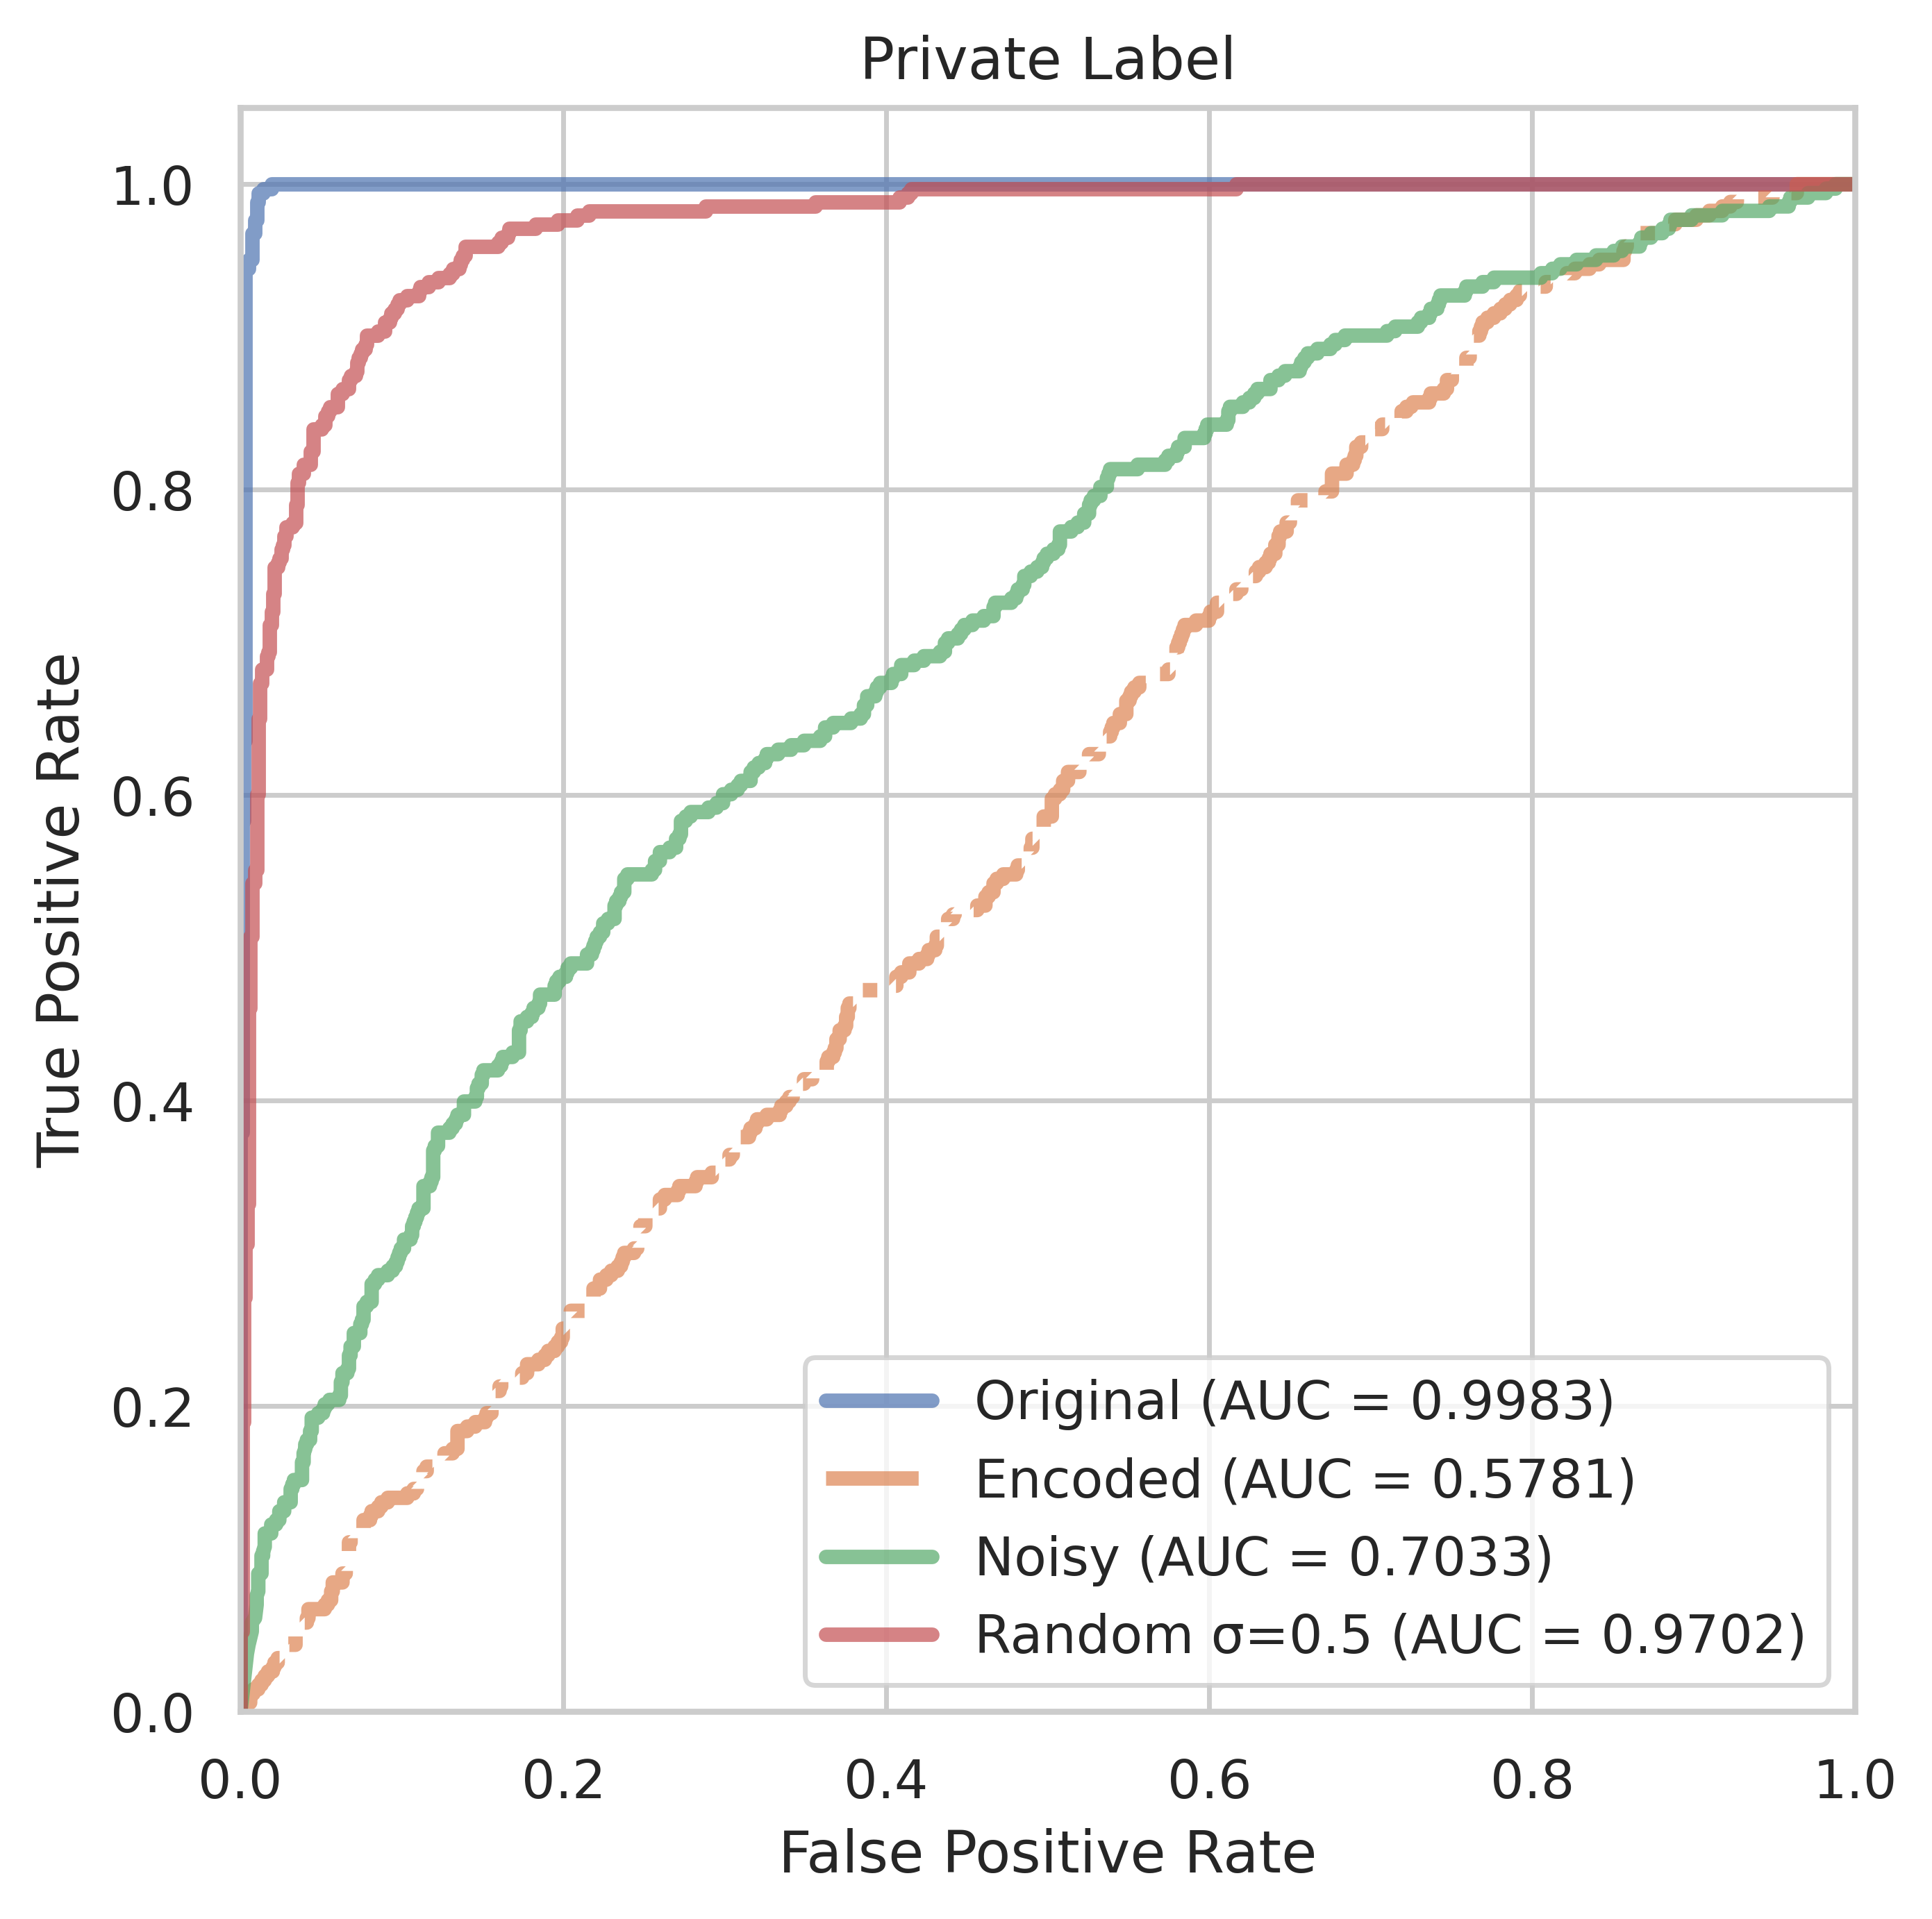

Combined ROC figure saved to: exps/training/2025-02-20_07-03-41/ROC_label2_all.png


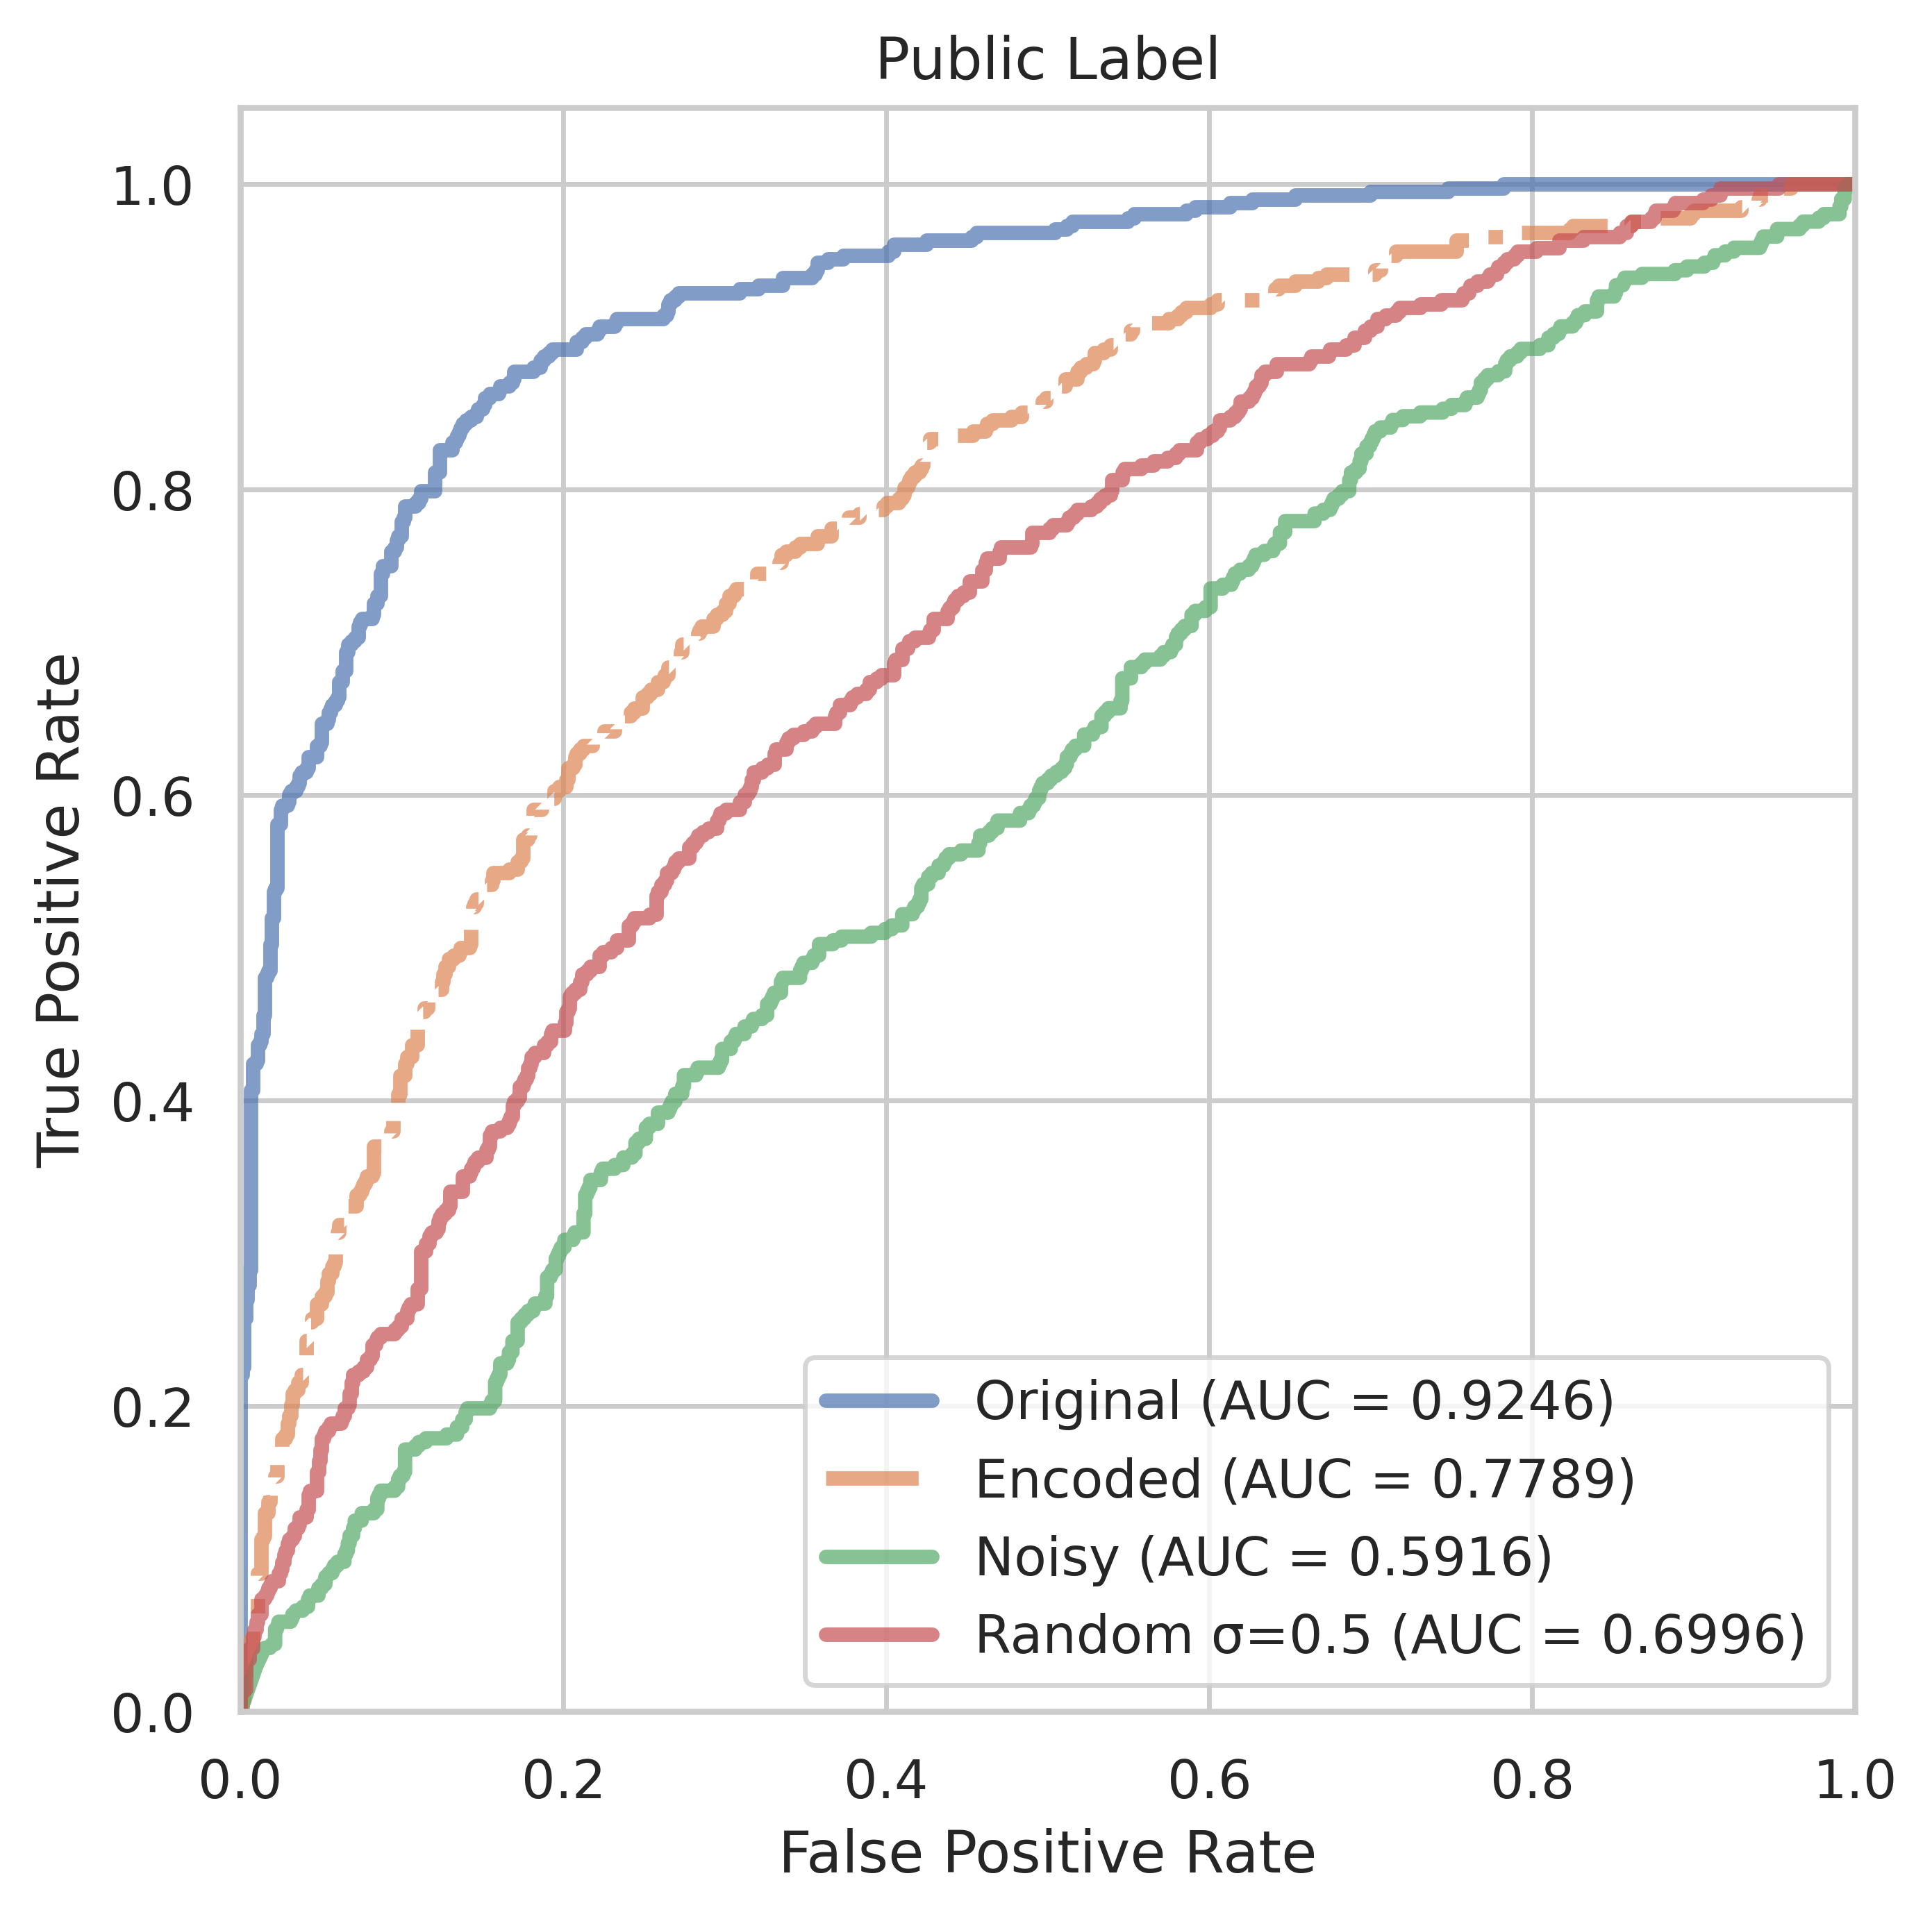


Performing t-SNE on Test Embeddings (Label1) - Original ...
t-SNE figure saved to: exps/training/2025-02-20_07-03-41/TSNE_original_label1.png


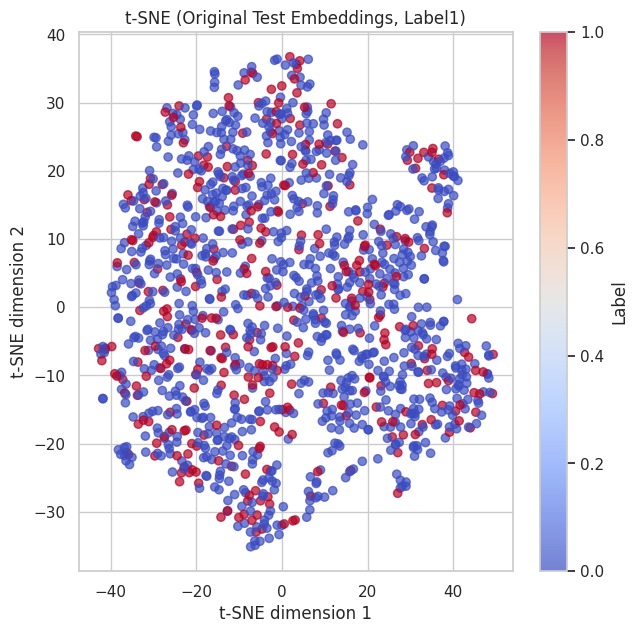

Performing t-SNE on Test Embeddings (Label1) - Encoded ...
t-SNE figure saved to: exps/training/2025-02-20_07-03-41/TSNE_encoded_label1.png


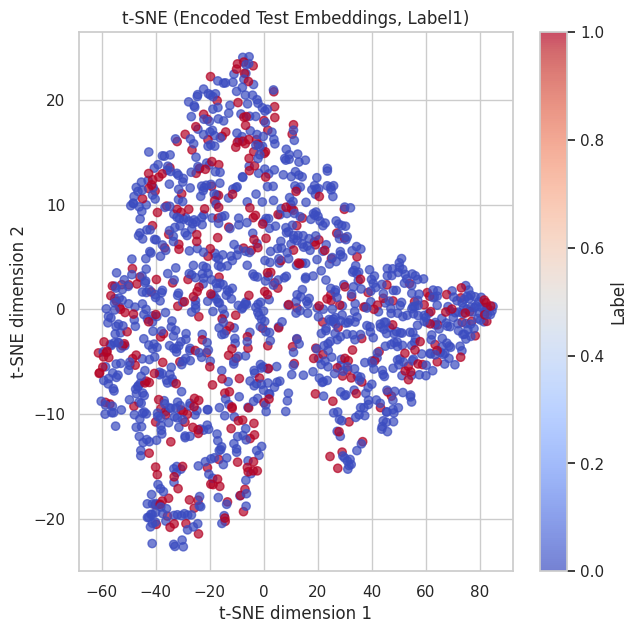

Performing t-SNE on Test Embeddings (Label1) - Noisy ...
t-SNE figure saved to: exps/training/2025-02-20_07-03-41/TSNE_noisy_label1.png


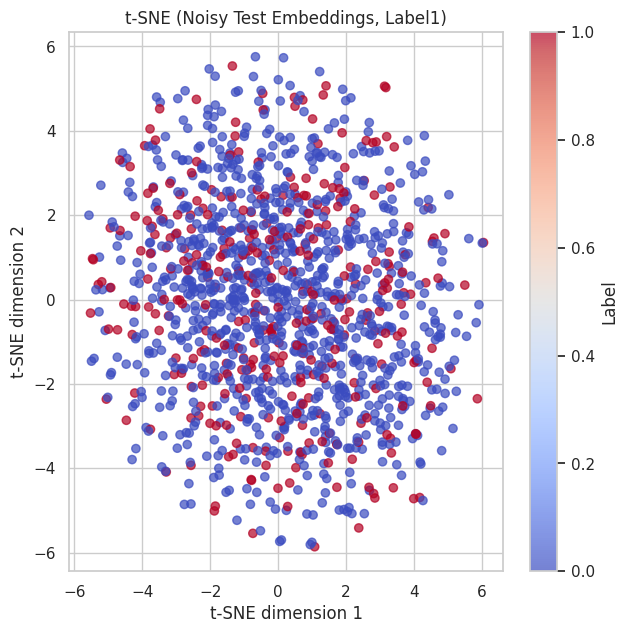

Performing t-SNE on Test Embeddings (Label1) - RandomEnc ...
t-SNE figure saved to: exps/training/2025-02-20_07-03-41/TSNE_rndenc_label1.png


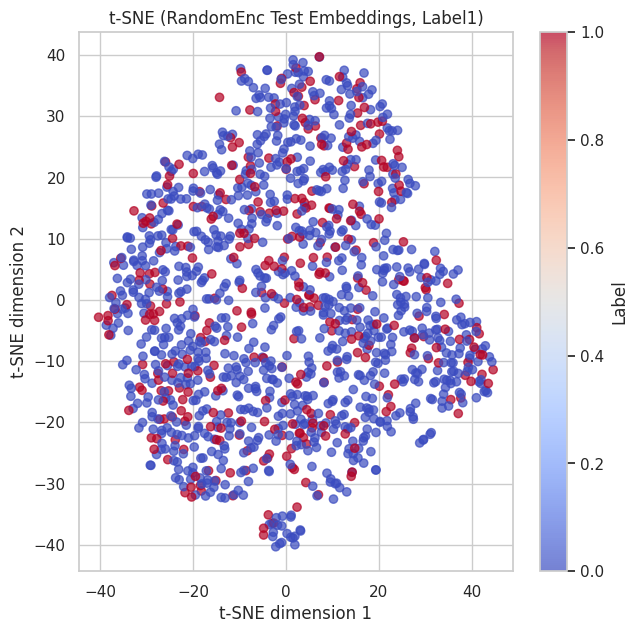

All combined ROC figures and t-SNE plots have been saved to: exps/training/2025-02-20_07-03-41


In [10]:
"""
analysis.ipynb

Notebook to perform ROC plotting, AUC calculation, and t-SNE visualization
on original vs. encoded vs. random encoder vs. noisy embeddings for both label 1 and label 2.
Saves the figures to the config directory.

Dependencies:
    - numpy
    - matplotlib
    - seaborn
    - scikit-learn
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.manifold import TSNE

# Seaborn style
sns.set(style="whitegrid")


def plot_roc_curve_multiple(
    preds_list,
    labels_list,
    curve_names,
    title="ROC Comparison",
    save_path=None
):
    """
    Plot multiple ROC curves on a single figure and compute AUC for each.

    Args:
        preds_list (list of np.ndarray): List of prediction arrays (each in [0,1]).
        labels_list (list of np.ndarray): Corresponding ground truth label arrays (0 or 1).
        curve_names (list of str): Labels for each curve in the legend.
        title (str): Title for the plot.
        save_path (str or None): If given, saves the figure to that path.

    Returns:
        None
    """
    plt.figure(figsize=(6, 6), dpi=500)

    line_styles = ["-", "-.", "-", "-"]
    for i, (preds, labels, name) in enumerate(zip(preds_list, labels_list, curve_names)):
        linestyle = line_styles[i]
        fpr, tpr, _ = roc_curve(labels, preds)
        roc_auc = auc(fpr, tpr)
        plt.plot(
            fpr, tpr, lw=3, 
            label=f"{name} (AUC = {roc_auc:.4f})",
            linestyle=linestyle,
            alpha=0.7,
        )

    # Plot random guess line
    # plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")

    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Combined ROC figure saved to: {save_path}")

    plt.show()


def plot_roc_curve(preds, labels, title="ROC Curve", save_path=None):
    """
    Plot a single ROC curve and compute the AUC.

    This function plots one ROC curve given predictions and labels,
    and optionally saves the figure.

    Args:
        preds (np.ndarray): Model predictions in [0,1].
        labels (np.ndarray): Ground truth labels in {0,1}.
        title (str): Title for the plot.
        save_path (str or None): File path to save the figure (if not None).

    Returns:
        float: The computed AUC value.
    """
    fpr, tpr, _ = roc_curve(labels, preds)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
    # plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")

    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Figure saved to: {save_path}")

    plt.show()
    return roc_auc


def visualize_tsne(embeddings, labels, title="t-SNE Visualization", save_path=None):
    """
    Create a 2D t-SNE projection of high-dimensional embeddings and color by label.

    This function reduces the dimensionality of embeddings to 2D via t-SNE
    and plots them, optionally saving the figure.

    Args:
        embeddings (np.ndarray): N x D array of embeddings.
        labels (np.ndarray): Binary labels (0 or 1) to color the embeddings.
        title (str): Title for the plot.
        save_path (str or None): File path to save the figure (if not None).

    Returns:
        None
    """
    tsne = TSNE(n_components=2, random_state=42)
    reduced = tsne.fit_transform(embeddings)

    plt.figure(figsize=(7, 7))
    scatter = plt.scatter(
        reduced[:, 0],
        reduced[:, 1],
        c=labels,
        cmap="coolwarm",
        alpha=0.7
    )
    cbar = plt.colorbar(scatter)
    cbar.set_label("Label")
    plt.title(title)
    plt.xlabel("t-SNE dimension 1")
    plt.ylabel("t-SNE dimension 2")

    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"t-SNE figure saved to: {save_path}")

    plt.show()


# ============================
# Adjust these paths as needed
# ============================
config_path = "exps/training/2025-02-20_07-03-41"  # same directory used in your training script

# ------------------------------------------------------------------------------
# 1. Load predictions/labels for Label 1 from each scenario
# ------------------------------------------------------------------------------
pred1_orig = np.load(f"{config_path}/pred1_orig.npy")
labels1_orig = np.load(f"{config_path}/labels1_orig.npy")

pred1_enc = np.load(f"{config_path}/pred1_enc.npy")
labels1_enc = np.load(f"{config_path}/labels1_enc.npy")

pred1_noisy = np.load(f"{config_path}/pred1_noisy.npy")
labels1_noisy = np.load(f"{config_path}/labels1_noisy.npy")

pred1_rndenc = np.load(f"{config_path}/pred1_rndenc.npy")
labels1_rndenc = np.load(f"{config_path}/labels1_rndenc.npy")

# ------------------------------------------------------------------------------
# 2. Load predictions/labels for Label 2 from each scenario
# ------------------------------------------------------------------------------
pred2_orig = np.load(f"{config_path}/pred2_orig.npy")
labels2_orig = np.load(f"{config_path}/labels2_orig.npy")

pred2_enc = np.load(f"{config_path}/pred2_enc.npy")
labels2_enc = np.load(f"{config_path}/labels2_enc.npy")

pred2_noisy = np.load(f"{config_path}/pred2_noisy.npy")
labels2_noisy = np.load(f"{config_path}/labels2_noisy.npy")

pred2_rndenc = np.load(f"{config_path}/pred2_rndenc.npy")
labels2_rndenc = np.load(f"{config_path}/labels2_rndenc.npy")


# ------------------------------------------------------------------------------
# 3. Single Combined ROC Plot for Label 1
# ------------------------------------------------------------------------------
plot_roc_curve_multiple(
    preds_list=[pred1_orig, pred1_enc, pred1_noisy, pred1_rndenc],
    labels_list=[labels1_orig, labels1_enc, labels1_noisy, labels1_rndenc],
    curve_names=["Original", "Encoded", "Noisy", "Random \u03C3=0.5"],
    title="Private Label",
    save_path=f"{config_path}/ROC_label1_all.png"
)

# ------------------------------------------------------------------------------
# 4. Single Combined ROC Plot for Label 2
# ------------------------------------------------------------------------------
plot_roc_curve_multiple(
    preds_list=[pred2_orig, pred2_enc, pred2_noisy, pred2_rndenc],
    labels_list=[labels2_orig, labels2_enc, labels2_noisy, labels2_rndenc],
    curve_names=["Original", "Encoded", "Noisy", "Random \u03C3=0.5"],
    title="Public Label",
    save_path=f"{config_path}/ROC_label2_all.png"
)

# ------------------------------------------------------------------------------
# 5. Load embeddings for T-SNE (optional, if you want to visualize them)
# ------------------------------------------------------------------------------
train_embeddings_original = np.load(f"{config_path}/train_embeddings_original.npy")
test_embeddings_original = np.load(f"{config_path}/test_embeddings_original.npy")

train_embeddings_encoded = np.load(f"{config_path}/train_embeddings_encoded.npy")
test_embeddings_encoded = np.load(f"{config_path}/test_embeddings_encoded.npy")

# Similarly for noisy
train_embeddings_noisy = np.load(f"{config_path}/train_embeddings_noisy.npy")
test_embeddings_noisy = np.load(f"{config_path}/test_embeddings_noisy.npy")

# And for random encoder
train_embeddings_rndenc = np.load(f"{config_path}/train_embeddings_rndenc.npy")
test_embeddings_rndenc = np.load(f"{config_path}/test_embeddings_rndenc.npy")


# ------------------------------------------------------------------------------
# 6. Example T-SNE (You can decide how to handle each scenario)
#    Below we do separate T-SNEs for test embeddings under label1's ground truth
# ------------------------------------------------------------------------------
print("\nPerforming t-SNE on Test Embeddings (Label1) - Original ...")
visualize_tsne(
    embeddings=test_embeddings_original,
    labels=labels1_orig,
    title="t-SNE (Original Test Embeddings, Label1)",
    save_path=f"{config_path}/TSNE_original_label1.png"
)

print("Performing t-SNE on Test Embeddings (Label1) - Encoded ...")
visualize_tsne(
    embeddings=test_embeddings_encoded,
    labels=labels1_orig[:len(test_embeddings_encoded)],
    title="t-SNE (Encoded Test Embeddings, Label1)",
    save_path=f"{config_path}/TSNE_encoded_label1.png"
)

print("Performing t-SNE on Test Embeddings (Label1) - Noisy ...")
visualize_tsne(
    embeddings=test_embeddings_noisy,
    labels=labels1_orig[:len(test_embeddings_noisy)],
    title="t-SNE (Noisy Test Embeddings, Label1)",
    save_path=f"{config_path}/TSNE_noisy_label1.png"
)

print("Performing t-SNE on Test Embeddings (Label1) - RandomEnc ...")
visualize_tsne(
    embeddings=test_embeddings_rndenc,
    labels=labels1_orig[:len(test_embeddings_rndenc)],
    title="t-SNE (RandomEnc Test Embeddings, Label1)",
    save_path=f"{config_path}/TSNE_rndenc_label1.png"
)

print("All combined ROC figures and t-SNE plots have been saved to:", config_path)

   epoch  utility_mi  privacy_mi
0      0    0.173343    0.397137
1      1    0.158415    0.252119
2      2    0.211684    0.243249
3      3    0.236570    0.165891
4      4    0.251628    0.123700
5      5    0.241029    0.133315
6      6    0.232665    0.145923
7      7    0.229622    0.119826
8      8    0.234095    0.072663


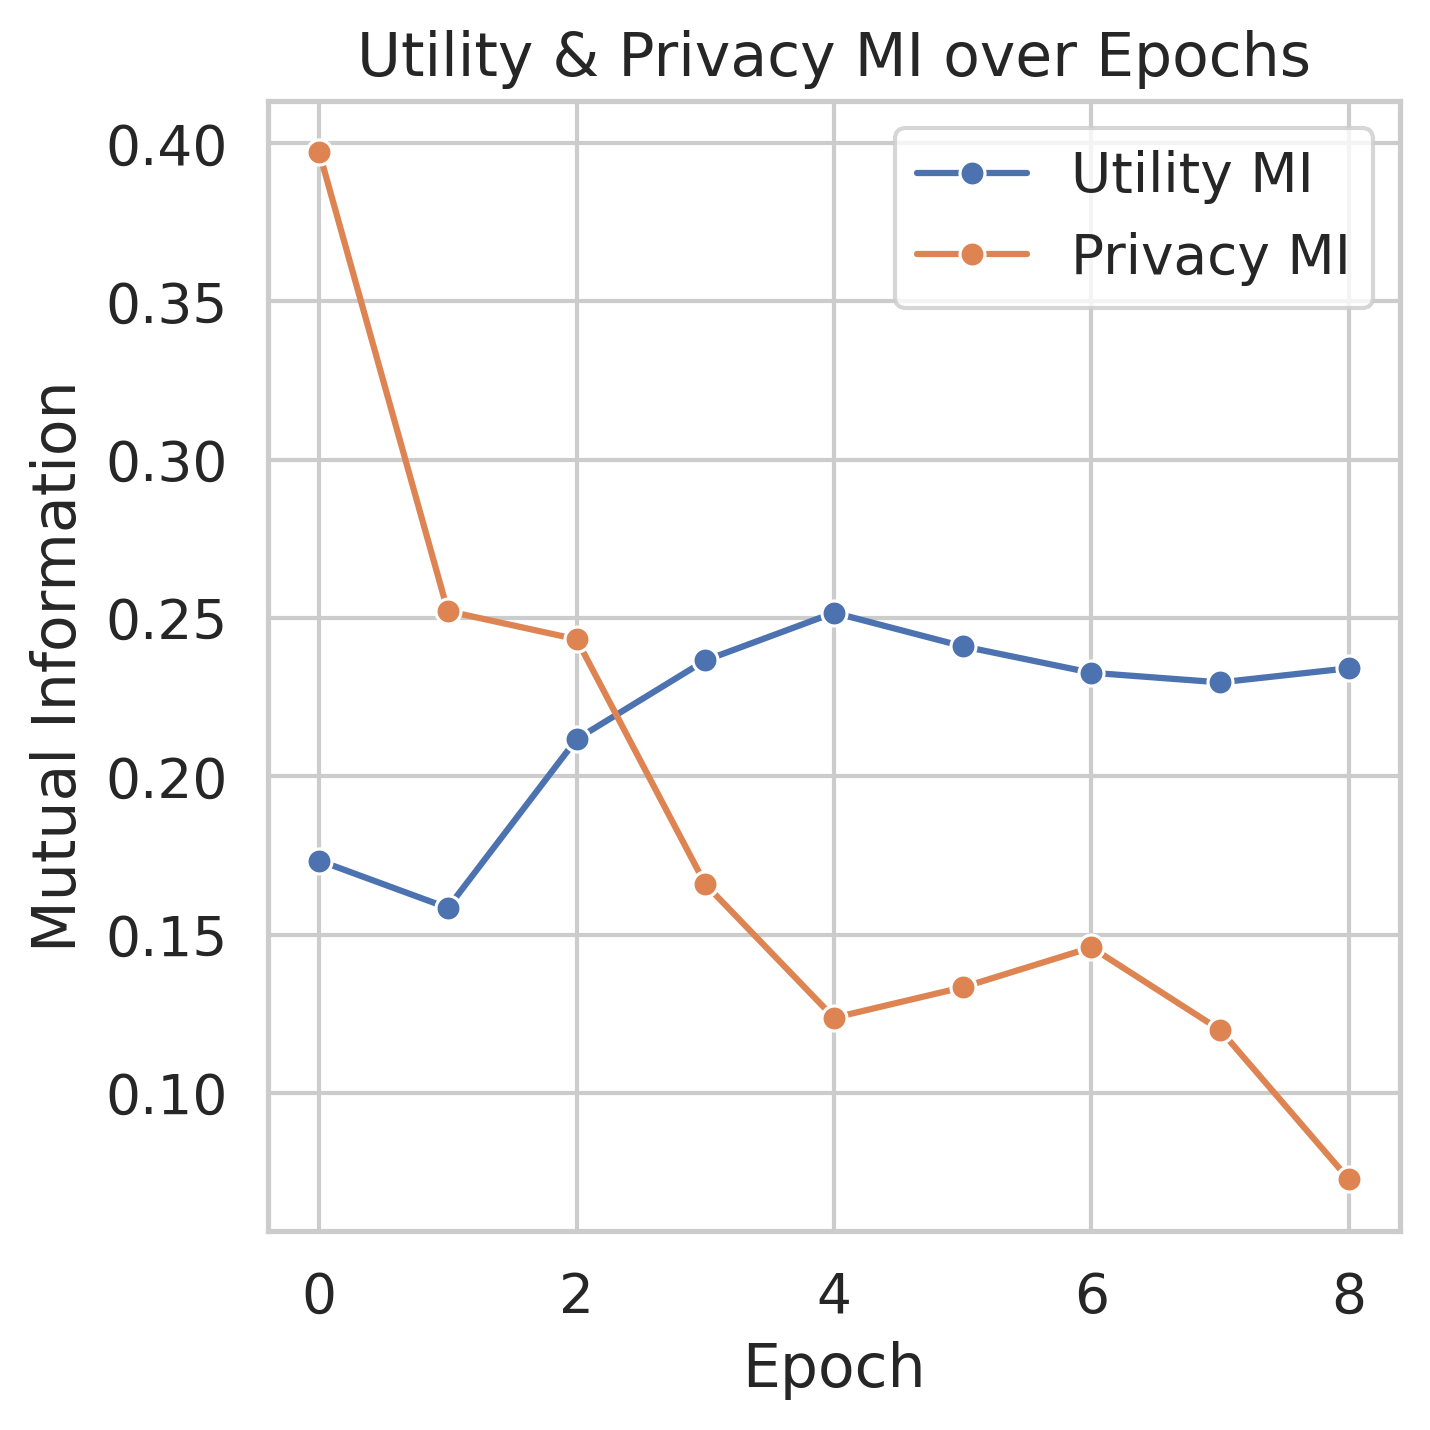

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample log data (as a multi-line string).
# In practice, you could read from a file or other source.
log_file = f"{config_path}/wavshape.log"
# Read the log_file
with open(log_file, 'r') as file:
    log_text = file.read()

# Regex patterns to match lines containing Utility MI and Privacy MI
utility_pattern = re.compile(
    r"Epoch:\s*(\d+).*Utility MI I\(T\(x\); L\(x\)\):\s*([\d\.]+)"
)
privacy_pattern = re.compile(
    r"Epoch:\s*(\d+).*Privacy MI I\(T\(x\); S\(x\)\):\s*([\d\.]+)"
)

# We'll store results in a dictionary of form: {epoch: {"utility": val, "privacy": val}}
epoch_data = {}

# Split the log text into lines and parse
for line in log_text.split("\n"):
    line = line.strip()
    # Check for utility
    match_utility = utility_pattern.search(line)
    if match_utility:
        ep = int(match_utility.group(1))
        val = float(match_utility.group(2))
        if ep not in epoch_data:
            epoch_data[ep] = {}
        epoch_data[ep]["utility"] = val
        continue

    # Check for privacy
    match_privacy = privacy_pattern.search(line)
    if match_privacy:
        ep = int(match_privacy.group(1))
        val = float(match_privacy.group(2))
        if ep not in epoch_data:
            epoch_data[ep] = {}
        epoch_data[ep]["privacy"] = val
        continue
0      0    0.142951    0.290029
1      1    0.163140    0.161743
2      2    0.186307    0.105375
3      3    0.190189    0.061719
4      4    0.195030    0.131918
5      5    0.191464    0.063329
6      6    0.225657    0.066023
7      7    0.211825    0.064383
8      8    0.235687    0.053450
# Convert the epoch_data dictionary into a pandas DataFrame
epoch_data = {
    0: {'utility': 0.142951, 'privacy': 0.290029},
    1: {'utility': 0.163140, 'privacy': 0.161743},
    2: {'utility': 0.186307, 'privacy': 0.105375},
    3: {'utility': 0.190189, 'privacy': 0.061719},
    4: {'utility': 0.195030, 'privacy': 0.131918},
    5: {'utility': 0.191464, 'privacy': 0.063329},
    6: {'utility': 0.225657, 'privacy': 0.066023},
    7: {'utility': 0.211825, 'privacy': 0.064383},
    8: {'utility': 0.235687, 'privacy': 0.053450}
}
rows = []
for ep, vals in epoch_data.items():
    rows.append([ep, vals.get("utility"), vals.get("privacy")])
    if ep == 8:
        break

df = pd.DataFrame(rows, columns=["epoch", "utility_mi", "privacy_mi"]).sort_values("epoch")
df.reset_index(drop=True, inplace=True)

# Optionally display the DataFrame
print(df)

# Plot using seaborn
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(5, 5), dpi=300)

sns.lineplot(data=df, x="epoch", y="utility_mi", marker="o", label="Utility MI")
sns.lineplot(data=df, x="epoch", y="privacy_mi", marker="o", label="Privacy MI")

plt.title("Utility & Privacy MI over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Mutual Information")
plt.legend()
plt.tight_layout()
plt.show()